In [ ]:
import pandas as pd

df = pd.read_excel('/content/drive/MyDrive/Data/tax-benefits-statistics-time-series-v3-filtered-2025-03-17T15-44-25Z.xlsx', sheet_name='Dataset')


/usr/local/lib/python3.11/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [ ]:
import pandas as pd

# Remove unnecessary rows and columns
df = df.dropna(how='all').reset_index(drop=True)

# Extract the header row (row 3 in the original file)
header_row = df.iloc[0]  # Assuming the header is in the 3rd row (index 2)
df = df[1:]  # Remove the first 3 rows (metadata and headers)
df.columns = header_row  # Set the header row as column names

# Convert year columns to single years
df.columns = [str(col).split('-')[0] if '-' in str(col) else str(col) for col in df.columns]

# Convert float years to integers (e.g., 1977.0 -> 1977)
df.columns = [str(int(float(col))) if str(col).replace('.', '').isdigit() else col for col in df.columns]

# Convert to long format
df_long = df.melt(
    id_vars=['Geography', 'Geography code', 'Quintile', 'AveragesAndPercentiles', 'Income', 'Deflation'],
    var_name='Year',
    value_name='Value'
)

# Convert Year to integer
df_long['Year'] = df_long['Year'].astype(int)

# Drop rows with missing values in the 'Value' column
df_long = df_long.dropna(subset=['Value'])

# Save cleaned data to a new file
df_long.to_csv('cleaned_tax_benefits_data.csv', index=False)

# Display the cleaned dataset
print(df_long.head())

        Geography Geography code Quintile AveragesAndPercentiles      Income  \
0  United Kingdom      K02000001      1st                   Mean  Disposable   
1  United Kingdom      K02000001      1st                   Mean  Disposable   
2  United Kingdom      K02000001      1st                   Mean       Final   
3  United Kingdom      K02000001      1st                   Mean       Final   
4  United Kingdom      K02000001      1st                   Mean       Gross   

          Deflation  Year   Value  
0    Deflated value  1977  7225.0  
1  Undeflated value  1977  1472.0  
2    Deflated value  1977  9302.0  
3  Undeflated value  1977  1895.0  
4    Deflated value  1977  8791.0  


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the cleaned dataset
df_long = pd.read_csv('cleaned_tax_benefits_data.csv')

# Display the first few rows
print(df_long.head())

        Geography Geography code Quintile AveragesAndPercentiles      Income  \
0  United Kingdom      K02000001      1st                   Mean  Disposable   
1  United Kingdom      K02000001      1st                   Mean  Disposable   
2  United Kingdom      K02000001      1st                   Mean       Final   
3  United Kingdom      K02000001      1st                   Mean       Final   
4  United Kingdom      K02000001      1st                   Mean       Gross   

          Deflation  Year   Value  
0    Deflated value  1977  7225.0  
1  Undeflated value  1977  1472.0  
2    Deflated value  1977  9302.0  
3  Undeflated value  1977  1895.0  
4    Deflated value  1977  8791.0  


In [ ]:
print(df_long.shape)

(5280, 8)


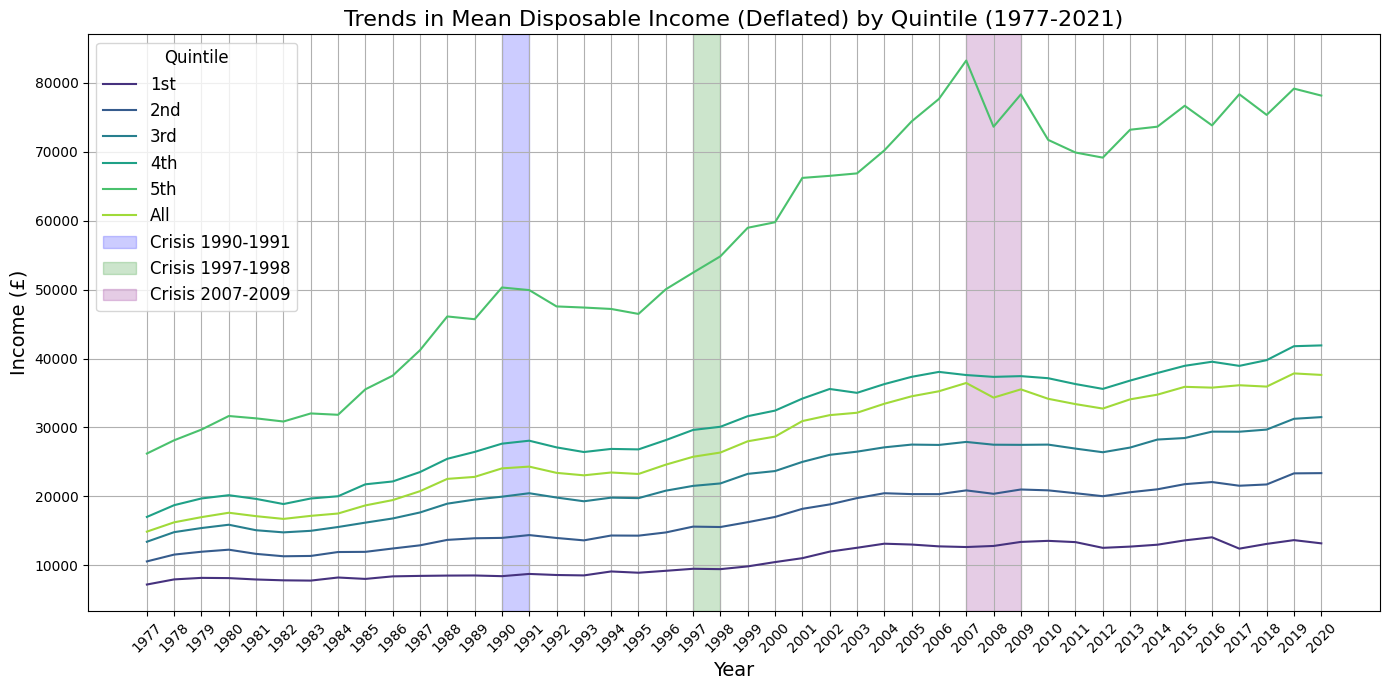

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter for disposable income (mean, deflated)
disposable_income = df_long[(df_long['Income'] == 'Disposable') &
                            (df_long['Deflation'] == 'Deflated value') &
                            (df_long['AveragesAndPercentiles'] == 'Mean')]

# Ensure the data is sorted by Year for proper plotting
disposable_income = disposable_income.sort_values(by='Year')

crisis_periods = {
    #(1973, 1975): 'red',  # 1973-1975 Oil Crisis
    (1990, 1991): 'blue',  # 1990-1991 Recession
    (1997, 1998): 'green',  # 1997-1998 Asian Financial Crisis
    (2007, 2009): 'purple',  # 2008 Global Financial Crisis
    #(2022, 2023): 'orange'   # 2022 Energy & Inflation Crisis
}


# Plot trends over time for every year
plt.figure(figsize=(14, 7))
sns.lineplot(data=disposable_income, x='Year', y='Value', hue='Quintile', palette='viridis')

# Add title and labels
plt.title('Trends in Mean Disposable Income (Deflated) by Quintile (1977-2021)', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Income (£)', fontsize=14)

# Add shaded regions for crisis periods
for (start, end), color in crisis_periods.items():
    plt.axvspan(start, end, color=color, alpha=0.2, label=f'Crisis {start}-{end}')  # Transparent shading


# Customize the legend
plt.legend(title='Quintile', title_fontsize=12, fontsize=12)

# Add grid for better readability
plt.grid(True)

# Ensure every year is shown on the x-axis
plt.xticks(ticks=disposable_income['Year'].unique(), rotation=45)

# Show the plot
plt.tight_layout()
plt.show()

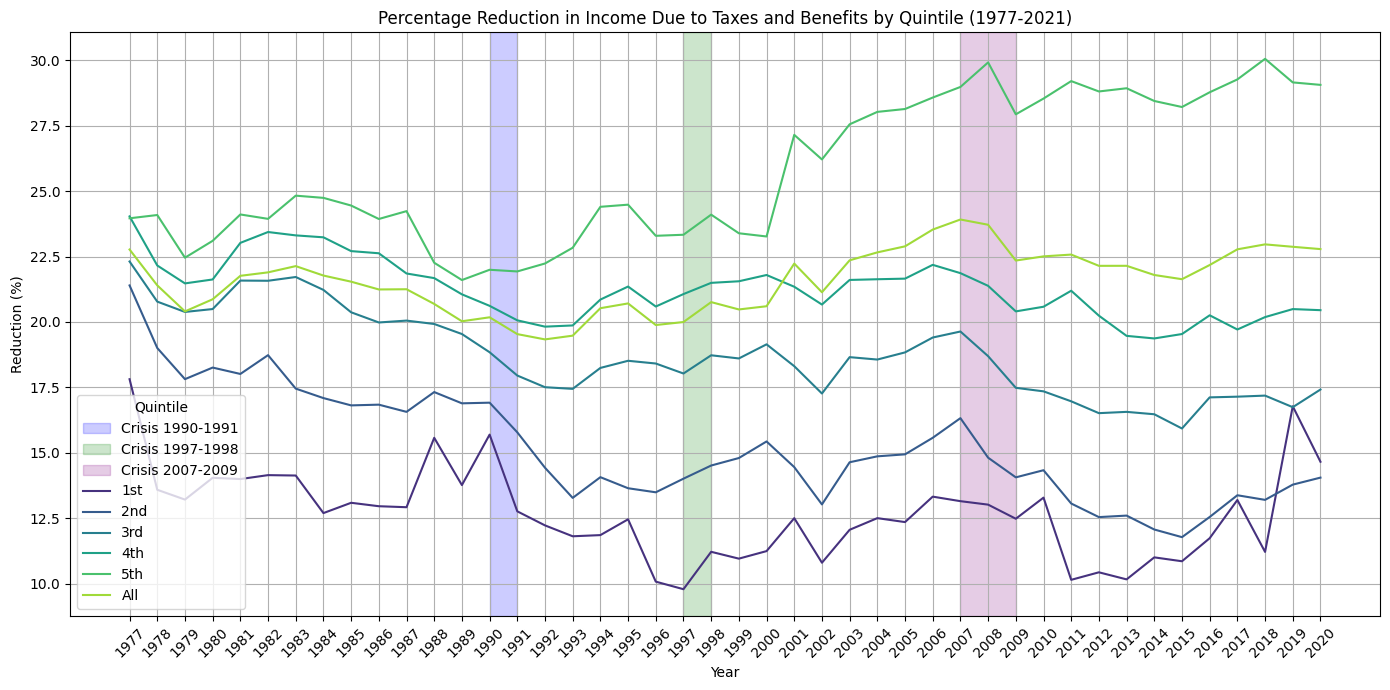

In [ ]:
# Filter for gross and disposable income (mean, deflated)
gross_income = df_long[(df_long['Income'] == 'Gross') &
                      (df_long['Deflation'] == 'Deflated value') &
                      (df_long['AveragesAndPercentiles'] == 'Mean')]
disposable_income = df_long[(df_long['Income'] == 'Disposable') &
                            (df_long['Deflation'] == 'Deflated value') &
                            (df_long['AveragesAndPercentiles'] == 'Mean')]

# Merge gross and disposable income
income_comparison = pd.merge(gross_income, disposable_income, on=['Geography', 'Geography code', 'Quintile', 'Year'], suffixes=('_gross', '_disposable'))

# Calculate percentage reduction due to taxes and benefits
income_comparison['Reduction (%)'] = ((income_comparison['Value_gross'] - income_comparison['Value_disposable']) / income_comparison['Value_gross']) * 100

# Plot reduction over time
plt.figure(figsize=(14, 7))
# Add shaded regions for crisis periods
for (start, end), color in crisis_periods.items():
    plt.axvspan(start, end, color=color, alpha=0.2, label=f'Crisis {start}-{end}')  # Transparent shading

sns.lineplot(data=income_comparison, x='Year', y='Reduction (%)', hue='Quintile', palette='viridis')
plt.title('Percentage Reduction in Income Due to Taxes and Benefits by Quintile (1977-2021)')
plt.xlabel('Year')
plt.ylabel('Reduction (%)')
plt.legend(title='Quintile')
plt.xticks(ticks=disposable_income['Year'].unique(), rotation=45)

# Show the plot
plt.tight_layout()
plt.grid(True)
plt.show()

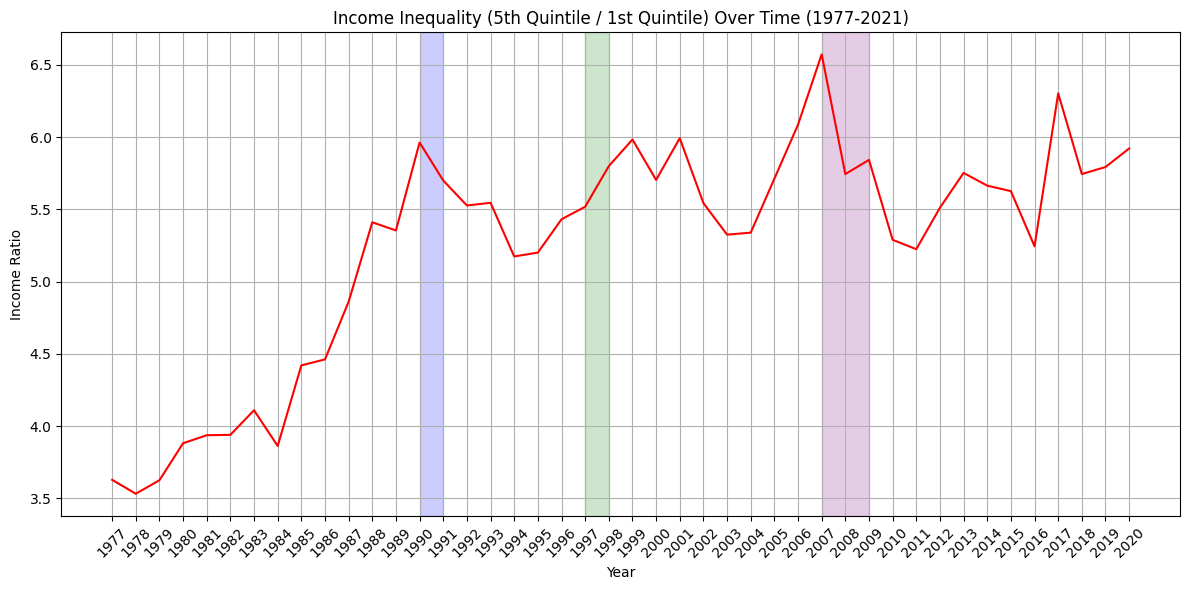

In [ ]:
# Filter for disposable income (mean, deflated)
quintile_1 = disposable_income[disposable_income['Quintile'] == '1st']
quintile_5 = disposable_income[disposable_income['Quintile'] == '5th']

# Merge quintile 1 and 5 data
inequality = pd.merge(quintile_1, quintile_5, on='Year', suffixes=('_1st', '_5th'))

# Calculate income ratio (5th quintile / 1st quintile)
inequality['Income Ratio'] = inequality['Value_5th'] / inequality['Value_1st']

# Plot income inequality over time
plt.figure(figsize=(12, 6))
sns.lineplot(data=inequality, x='Year', y='Income Ratio', color='red')
plt.title('Income Inequality (5th Quintile / 1st Quintile) Over Time (1977-2021)')
plt.xlabel('Year')
plt.ylabel('Income Ratio')
plt.xticks(ticks=disposable_income['Year'].unique(), rotation=45)
# Add shaded regions for crisis periods
for (start, end), color in crisis_periods.items():
    plt.axvspan(start, end, color=color, alpha=0.2, label=f'Crisis {start}-{end}')  # Transparent shading

# Show the plot
plt.tight_layout()
plt.grid(True)
plt.show()

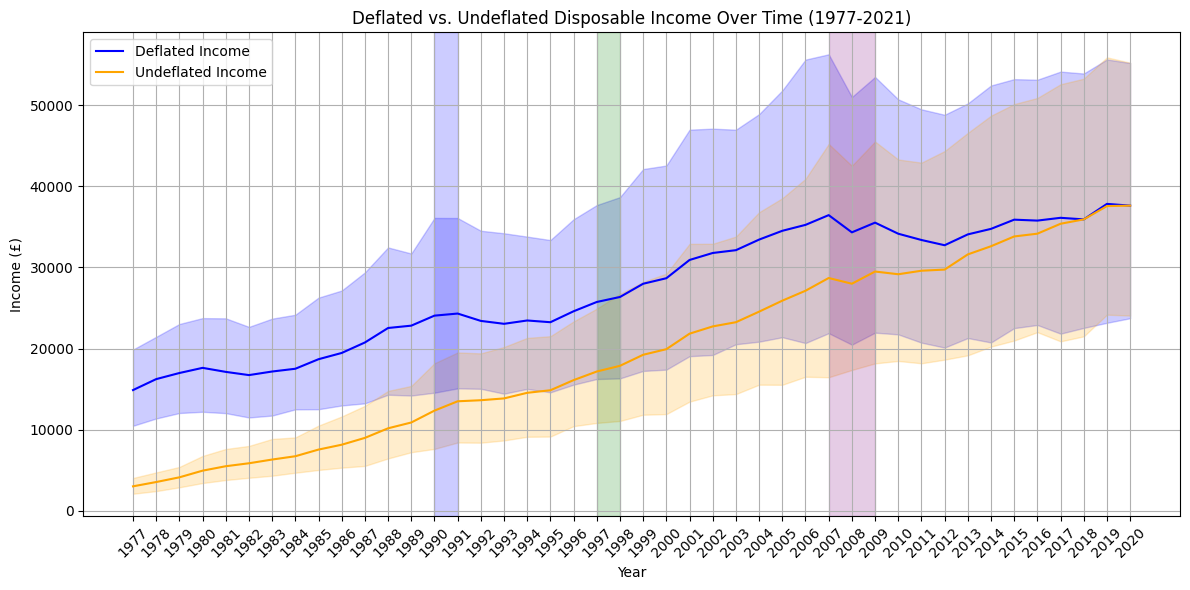

In [ ]:
# Filter for disposable income (mean, deflated and undeflated)
deflated_income = df_long[(df_long['Income'] == 'Disposable') &
                          (df_long['Deflation'] == 'Deflated value') &
                          (df_long['AveragesAndPercentiles'] == 'Mean')]
undeflated_income = df_long[(df_long['Income'] == 'Disposable') &
                            (df_long['Deflation'] == 'Undeflated value') &
                            (df_long['AveragesAndPercentiles'] == 'Mean')]

# Merge deflated and undeflated income
income_comparison = pd.merge(deflated_income, undeflated_income, on=['Geography', 'Geography code', 'Quintile', 'Year'], suffixes=('_deflated', '_undeflated'))

# Plot deflated vs. undeflated income
plt.figure(figsize=(12, 6))
sns.lineplot(data=income_comparison, x='Year', y='Value_deflated', label='Deflated Income', color='blue')
sns.lineplot(data=income_comparison, x='Year', y='Value_undeflated', label='Undeflated Income', color='orange')
plt.title('Deflated vs. Undeflated Disposable Income Over Time (1977-2021)')
plt.xlabel('Year')
plt.ylabel('Income (£)')
plt.legend()
plt.xticks(ticks=disposable_income['Year'].unique(), rotation=45)
# Add shaded regions for crisis periods
for (start, end), color in crisis_periods.items():
    plt.axvspan(start, end, color=color, alpha=0.2, label=f'Crisis {start}-{end}')  # Transparent shading

# Show the plot
plt.tight_layout()
plt.grid(True)
plt.show()

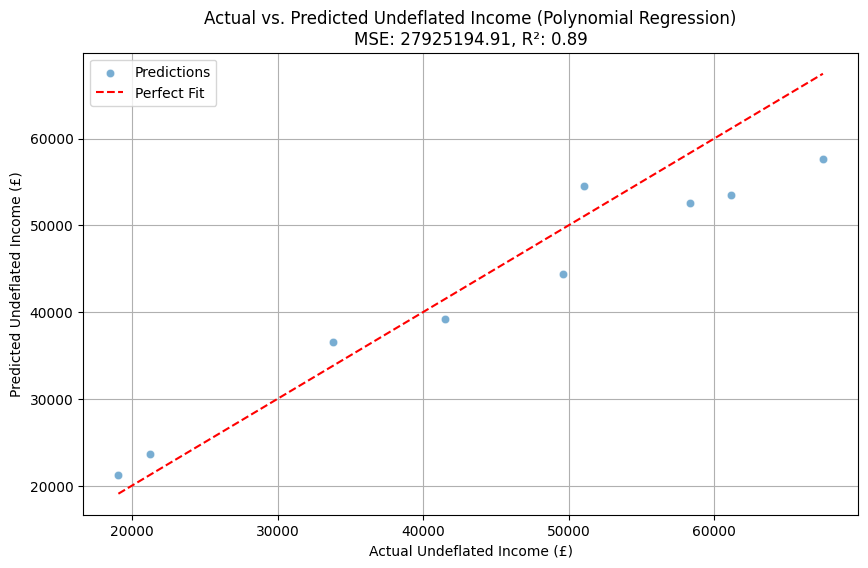

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Load dataset (assuming it's already preprocessed)
# df_long = pd.read_csv('cleaned_tax_benefits_data.csv') # Uncomment if loading from a CSV

# Sample dataset creation (for demonstration purposes)
np.random.seed(42)
years = np.arange(1977, 2022)
values_deflated = np.random.uniform(10000, 50000, len(years))
values_undeflated = values_deflated * np.random.uniform(1.1, 1.5, len(years))

# Create DataFrame
income_comparison = pd.DataFrame({
    'Year': years,
    'Value_deflated': values_deflated,
    'Value_undeflated': values_undeflated
})

# Features and target
X = income_comparison[['Value_deflated']]
y = income_comparison['Value_undeflated']

# Transform features for polynomial regression (degree=2)
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)

# Train model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluate model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Plot actual vs predicted undeflated income
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6, label="Predictions")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label="Perfect Fit")  # Diagonal line
plt.xlabel('Actual Undeflated Income (£)')
plt.ylabel('Predicted Undeflated Income (£)')
plt.title(f'Actual vs. Predicted Undeflated Income (Polynomial Regression)\nMSE: {mse:.2f}, R²: {r2:.2f}')
plt.legend()
plt.grid(True)
plt.show()


Mean Squared Error (MSE): 116237907.39803794
R-squared (R2): 0.6475509199518139
Year: 13187.80381343844
Quintile: -303124.16148548725
Income: 62993.508895970124
Deflation: -279464.6935837761
Year^2: -3.2518536565476097
Year Quintile: 158.78753782415907
Year Income: -28.831903916279686
Year Deflation: 277.7892426143221
Quintile^2: -1728.4322679259342
Quintile Income: 187.96087536566864
Quintile Deflation: -1817.353290346936
Income^2: -1669.1893403918727
Income Deflation: 224.47904460301075
Deflation^2: -279464.69358376664
Predicted Income: £8817.15


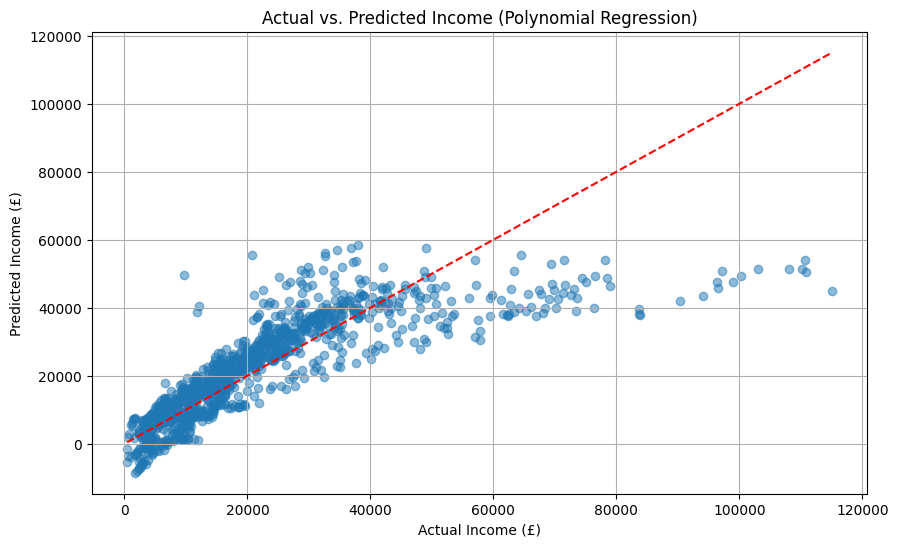

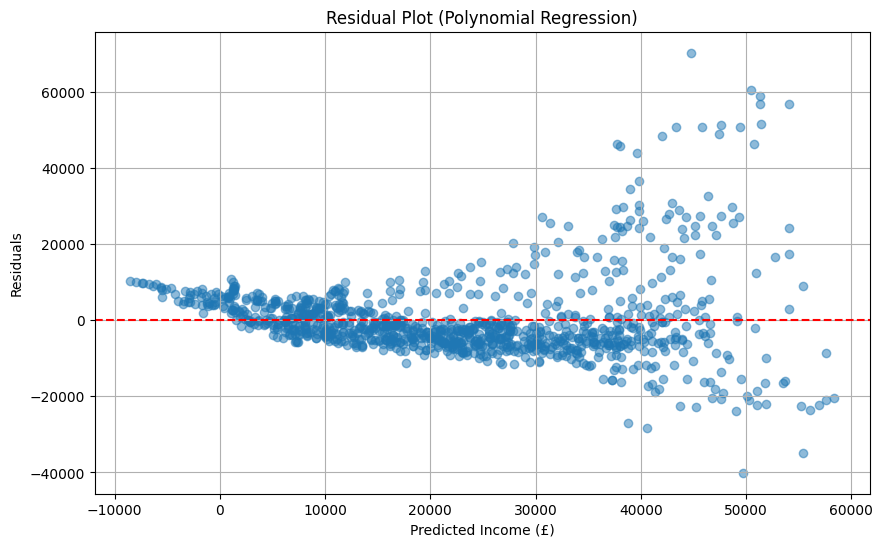

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Load the cleaned dataset
df_long = pd.read_csv('cleaned_tax_benefits_data.csv')

# Encode categorical variables
label_encoders = {}
categorical_cols = ['Quintile', 'Income', 'Deflation']

for col in categorical_cols:
    le = LabelEncoder()
    df_long[col] = le.fit_transform(df_long[col])
    label_encoders[col] = le  # Save encoders for later use

# Select features and target variable
X = df_long[['Year', 'Quintile', 'Income', 'Deflation']]
y = df_long['Value']

# Create polynomial features (degree=2 for quadratic terms)
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)

# Train the polynomial regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R2): {r2}")

# Get the coefficients
coefficients = model.coef_
feature_names = poly.get_feature_names_out(X.columns)

# Display the coefficients
for feature, coef in zip(feature_names, coefficients):
    print(f"{feature}: {coef}")

# Example: Predict income for the 1st quintile in 2021 with deflated values
example = pd.DataFrame({
    'Year': [2021],
    'Quintile': [label_encoders['Quintile'].transform(['1st'])[0]],
    'Income': [label_encoders['Income'].transform(['Disposable'])[0]],
    'Deflation': [label_encoders['Deflation'].transform(['Deflated value'])[0]]
})

# Transform the example data into polynomial features
example_poly = poly.transform(example)

# Make the prediction
predicted_income = model.predict(example_poly)
print(f"Predicted Income: £{predicted_income[0]:.2f}")

# Plot actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Diagonal line
plt.xlabel('Actual Income (£)')
plt.ylabel('Predicted Income (£)')
plt.title('Actual vs. Predicted Income (Polynomial Regression)')
plt.grid(True)
plt.show()


# Calculate residuals
residuals = y_test - y_pred

# Plot residuals
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')  # Horizontal line at 0
plt.xlabel('Predicted Income (£)')
plt.ylabel('Residuals')
plt.title('Residual Plot (Polynomial Regression)')
plt.grid(True)
plt.show()

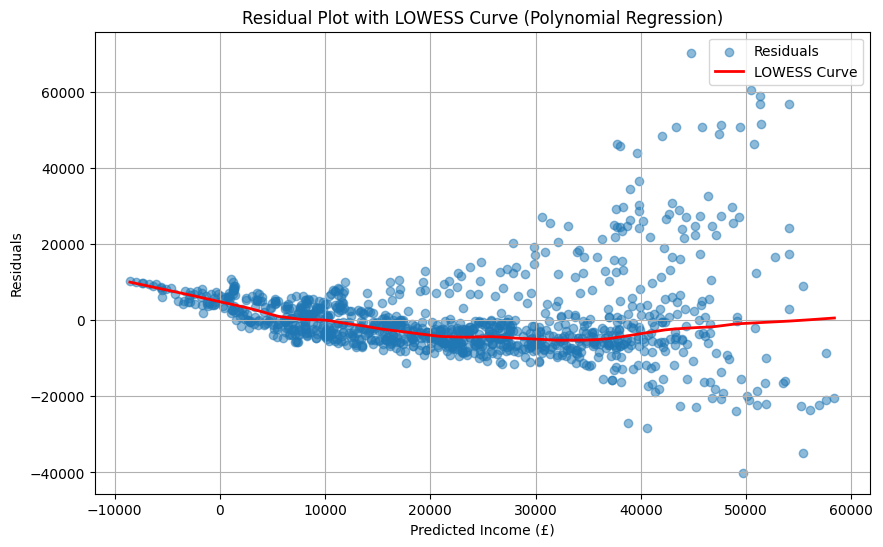

In [ ]:
import statsmodels.api as sm

# Sort data for smooth plotting
sorted_indices = np.argsort(y_pred)
y_pred_sorted = np.array(y_pred)[sorted_indices]
residuals_sorted = np.array(residuals)[sorted_indices]

# Apply LOWESS smoothing (frac controls smoothness)
lowess_result = sm.nonparametric.lowess(residuals_sorted, y_pred_sorted, frac=0.2)

# Extract smoothed x and y values
smoothed_x = lowess_result[:, 0]
smoothed_y = lowess_result[:, 1]

# Plot residuals scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5, label='Residuals')

# Plot the smooth LOWESS curve
plt.plot(smoothed_x, smoothed_y, color='r', linewidth=2, label='LOWESS Curve')

# Labels and title
plt.xlabel('Predicted Income (£)')
plt.ylabel('Residuals')
plt.title('Residual Plot with LOWESS Curve (Polynomial Regression)')
plt.legend()
plt.grid(True)
plt.show()


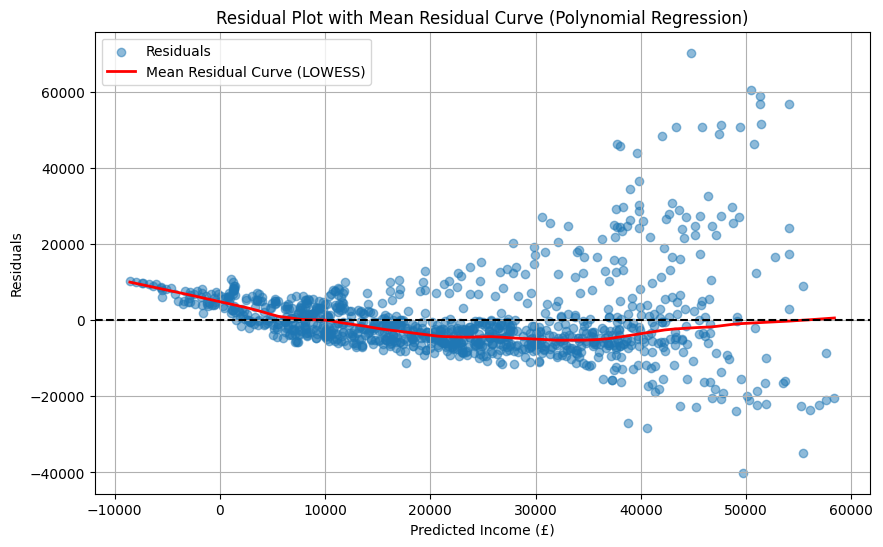

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm  # For LOWESS

# Calculate residuals
residuals = y_test - y_pred

# Apply LOWESS smoothing
lowess_result = sm.nonparametric.lowess(residuals, y_pred, frac=0.2)

# Extract smoothed values
smoothed_x = lowess_result[:, 0]  # Predicted values
smoothed_y = lowess_result[:, 1]  # Smoothed residuals

# Plot residuals as scatter
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5, label="Residuals")

# Plot LOWESS curve
plt.plot(smoothed_x, smoothed_y, color='red', linewidth=2, label="Mean Residual Curve (LOWESS)")

# Add reference line at zero residual
plt.axhline(y=0, color='black', linestyle='--')

# Labels and title
plt.xlabel("Predicted Income (£)")
plt.ylabel("Residuals")
plt.title("Residual Plot with Mean Residual Curve (Polynomial Regression)")
plt.legend()
plt.grid(True)
plt.show()


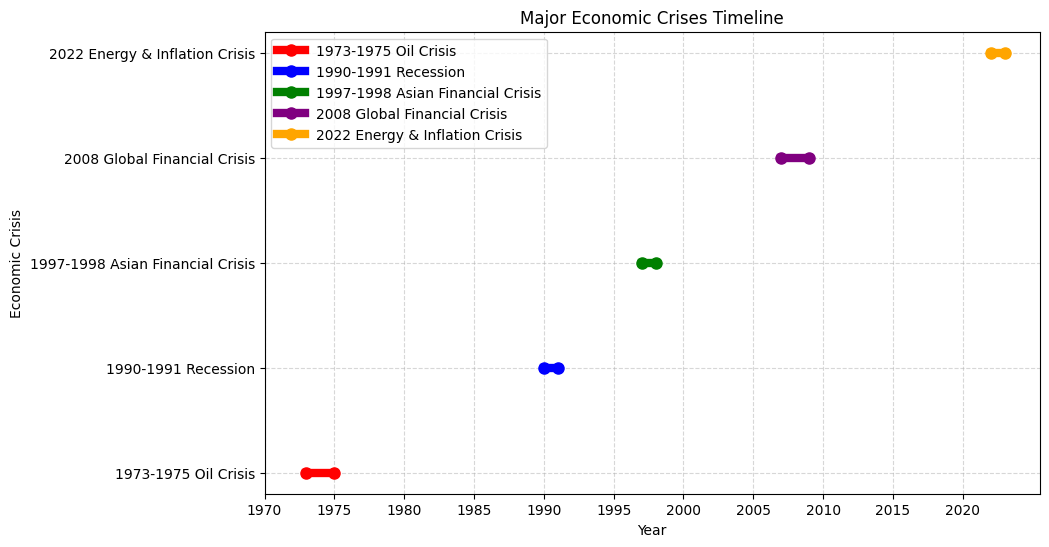

In [ ]:
import matplotlib.pyplot as plt

# Define crisis events with start and end years
crises = [
    ("1973-1975 Oil Crisis", 1973, 1975, 'red'),
    ("1990-1991 Recession", 1990, 1991, 'blue'),
    ("1997-1998 Asian Financial Crisis", 1997, 1998, 'green'),
    ("2008 Global Financial Crisis", 2007, 2009, 'purple'),
    ("2022 Energy & Inflation Crisis", 2022, 2023, 'orange')  # Ongoing crisis
]

# Plot the timeline
plt.figure(figsize=(10, 6))

for crisis, start, end, color in crises:
    plt.plot([start, end], [crisis, crisis], color=color, linewidth=6, marker='o', markersize=8, label=crisis)

# Customize plot
plt.xlabel("Year")
plt.ylabel("Economic Crisis")
plt.title("Major Economic Crises Timeline")
plt.grid(True, linestyle="--", alpha=0.5)
plt.xticks(range(1970, 2025, 5))  # Adjust x-axis range
plt.legend()

# Show the plot
plt.show()


Merged DataFrame:
  Title_x  Unemployment Rate  Year  Title_y  Inflation Rate  GDP Growth
0    1989                7.2  1989     1989             5.7       0.325
1    1989                7.2  1989  1989 Q1             5.8       0.325
2    1989                7.2  1989  1989 Q2             5.8       0.325
3    1989                7.2  1989  1989 Q3             5.6       0.325
4    1989                7.2  1989  1989 Q4             5.7       0.325
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10336 entries, 0 to 10335
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Title_x            10336 non-null  object 
 1   Unemployment Rate  10336 non-null  float64
 2   Year               10336 non-null  int64  
 3   Title_y            10336 non-null  object 
 4   Inflation Rate     10336 non-null  float64
 5   GDP Growth         10336 non-null  float64
dtypes: float64(3), int64(1), object(2)
memory usage: 484.

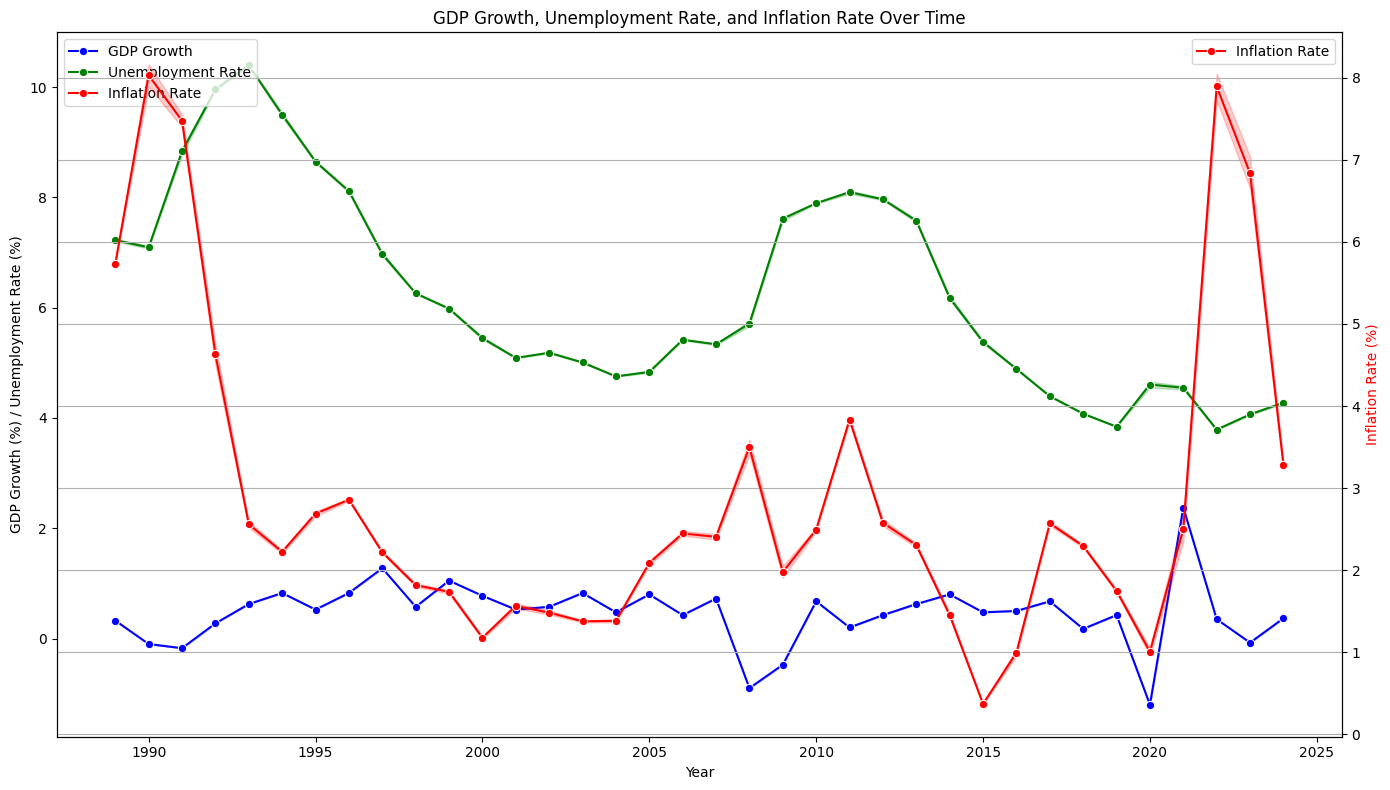

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the datasets
unemployment_df = pd.read_csv("/content/drive/MyDrive/Data/Copy of 10001.Tab_Unemployment_rate.csv")
gdp_df = pd.read_csv("/content/drive/MyDrive/Data/Copy of 10002.Tab_GDP.csv")
inflation_df = pd.read_csv("/content/drive/MyDrive/Data/Copy of 10003.Tab_Inflation.csv")

# Simplify column names
unemployment_df.columns = ["Title", "Unemployment Rate"]
gdp_df.columns = ["Title", "GDP Growth"]
inflation_df.columns = ["Title", "Inflation Rate"]

# Extract Year and numeric values
unemployment_df["Year"] = unemployment_df["Title"].str.extract(r'(\d{4})')
unemployment_df["Unemployment Rate"] = pd.to_numeric(unemployment_df["Unemployment Rate"], errors="coerce")

gdp_df["Year"] = gdp_df["Title"].str.extract(r'(\d{4})')
gdp_df["GDP Growth"] = pd.to_numeric(gdp_df["GDP Growth"], errors="coerce")

inflation_df["Year"] = inflation_df["Title"].str.extract(r'(\d{4})')
inflation_df["Inflation Rate"] = pd.to_numeric(inflation_df["Inflation Rate"], errors="coerce")

# Aggregate GDP data by year
gdp_annual = gdp_df.groupby("Year")["GDP Growth"].mean().reset_index()

# Merge datasets
merged_df = pd.merge(unemployment_df, inflation_df, on="Year", how="inner")
merged_df = pd.merge(merged_df, gdp_annual, on="Year", how="inner")

# Convert Year to integer
merged_df["Year"] = merged_df["Year"].astype(int)

# Debugging: Print the merged DataFrame
print("Merged DataFrame:")
print(merged_df.head())
print(merged_df.info())

# Debugging: Check for missing values
print("\nMissing Values:")
print(merged_df.isnull().sum())

# Plot GDP Growth, Unemployment Rate, and Inflation Rate in one graph
plt.figure(figsize=(14, 8))

# Create the primary axis (for GDP Growth and Unemployment Rate)
ax1 = plt.gca()
sns.lineplot(data=merged_df, x="Year", y="GDP Growth", marker="o", color="blue", label="GDP Growth", ax=ax1)
sns.lineplot(data=merged_df, x="Year", y="Unemployment Rate", marker="o", color="green", label="Unemployment Rate", ax=ax1)

# Create the secondary axis (for Inflation Rate)
ax2 = ax1.twinx()
sns.lineplot(data=merged_df, x="Year", y="Inflation Rate", marker="o", color="red", label="Inflation Rate", ax=ax2)

# Add labels and titles
ax1.set_xlabel("Year")
ax1.set_ylabel("GDP Growth (%) / Unemployment Rate (%)", color="black")
ax2.set_ylabel("Inflation Rate (%)", color="red")
plt.title("GDP Growth, Unemployment Rate, and Inflation Rate Over Time")
plt.grid(True)

# Add legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left")

plt.tight_layout()
plt.show()

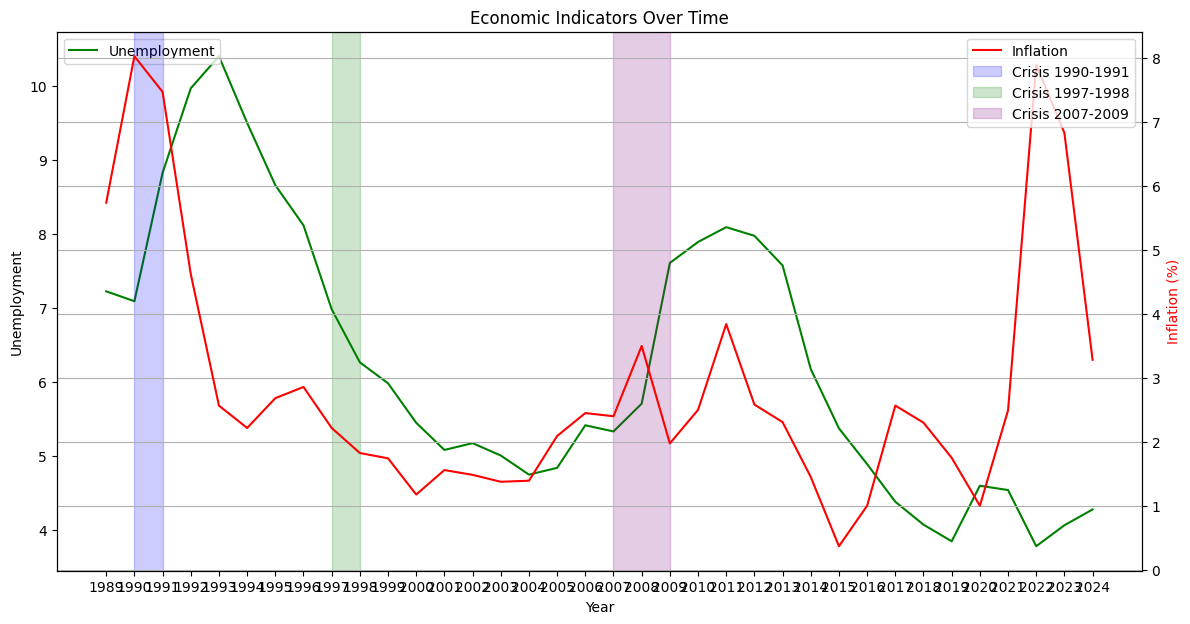

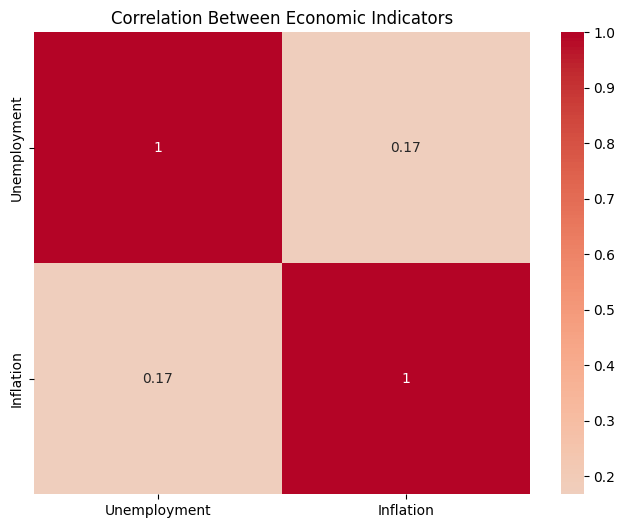


Descriptive Statistics:
              Year  Unemployment  Inflation
count    36.000000     36.000000  36.000000
mean   2006.500000      6.248519   2.876620
std      10.535654      1.852948   1.967046
min    1989.000000      3.783333   0.366667
25%    1997.750000      4.818750   1.695833
50%    2006.500000      5.579167   2.354167
75%    2015.250000      7.679167   2.964583
max    2024.000000     10.400000   8.033333


<Figure size 1400x800 with 0 Axes>

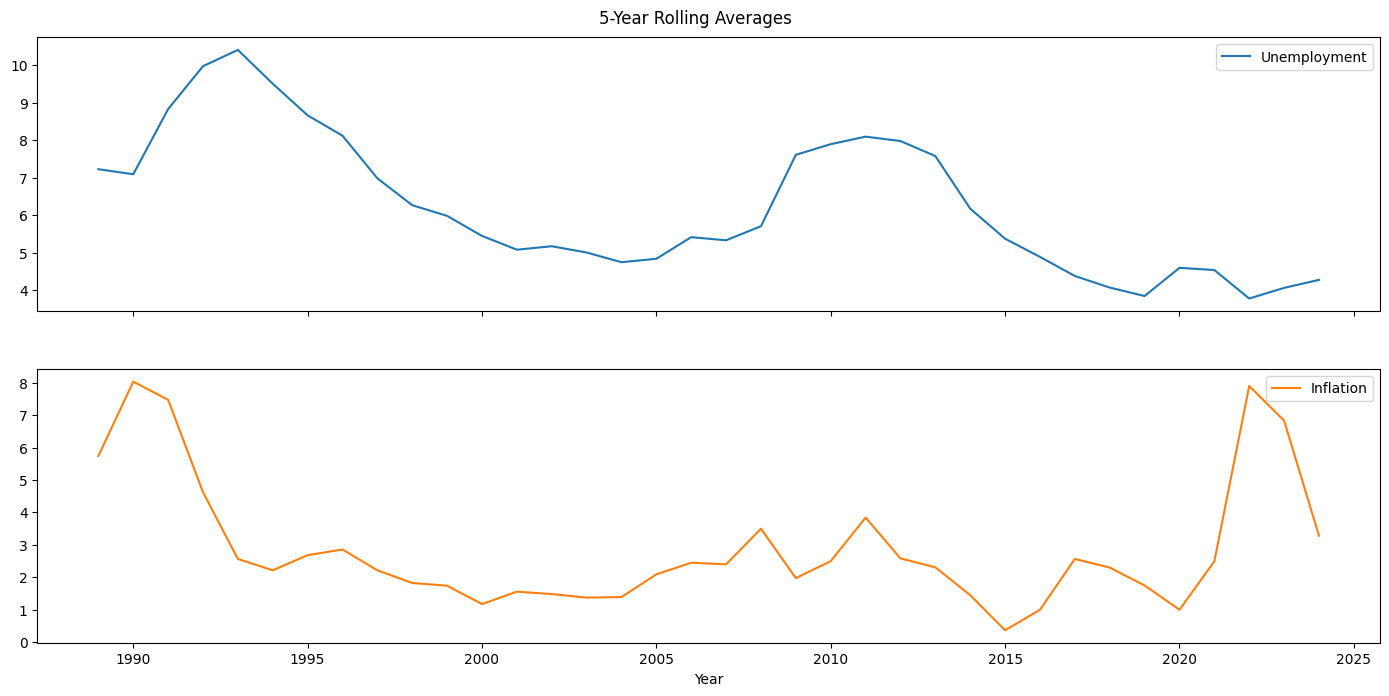

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import grangercausalitytests

# Load datasets
unemp = pd.read_csv("/content/drive/MyDrive/Data/Copy of Unemployment_rate_monthly.csv")
infl = pd.read_csv("/content/drive/MyDrive/Data/Copy of Inflation_monthly.csv")

# Process monthly data to annual averages
def process_monthly(df, value_name):
    melted = df.melt(id_vars='Year', var_name='Month', value_name=value_name)
    melted = melted[melted['Month'] != 'Year']  # Remove any residual year rows
    melted[value_name] = pd.to_numeric(melted[value_name], errors='coerce')
    annual = melted.groupby('Year')[value_name].mean().reset_index()
    annual['Year'] = annual['Year'].astype(int)
    return annual

crisis_periods = {
    #(1973, 1975): 'red',  # 1973-1975 Oil Crisis
    (1990, 1991): 'blue',  # 1990-1991 Recession
    (1997, 1998): 'green',  # 1997-1998 Asian Financial Crisis
    (2007, 2009): 'purple',  # 2008 Global Financial Crisis
    #(2022, 2023): 'orange'   # 2022 Energy & Inflation Crisis
}

unemp_annual = process_monthly(unemp, 'Unemployment')
infl_annual = process_monthly(infl, 'Inflation')


# Merge all data
merged = pd.merge(unemp_annual, infl_annual, on='Year', how='inner')
# Add shaded regions for crisis periods

# Visualization 1: Combined Time Series
plt.figure(figsize=(14, 7))
ax1 = plt.gca()
sns.lineplot(data=merged, x='Year', y='Unemployment', color='green', ax=ax1, label='Unemployment')


ax2 = ax1.twinx()
sns.lineplot(data=merged, x='Year', y='Inflation', color='red', ax=ax2, label='Inflation')

for (start, end), color in crisis_periods.items():
    plt.axvspan(start, end, color=color, alpha=0.2, label=f'Crisis {start}-{end}')  # Transparent shading

plt.grid(True)

plt.xticks(ticks=infl_annual['Year'].unique(), rotation=90)

ax1.set_xlabel('Year')
ax2.set_ylabel('Inflation (%)', color='red')
plt.title('Economic Indicators Over Time')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.grid(True)
plt.show()


# Visualization 2: Correlation Heatmap
corr_matrix = merged[['Unemployment', 'Inflation']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Between Economic Indicators')
plt.show()

# Statistical Analysis
print("\nDescriptive Statistics:")
print(merged.describe())

# Rolling 5-year averages
merged.set_index('Year', inplace=True)
rolling = merged.rolling(1).mean()
plt.figure(figsize=(14, 8))
rolling.plot(subplots=True, layout=(3,1), figsize=(14,10), title='5-Year Rolling Averages')
plt.tight_layout()
plt.show()

